# DDPG + 우리가 정의한 reward 추가한 humanoid

기존 DDPG에 생존시간이 길어질수록(생존시간의 기준: step)</br> reward를 0.1씩 더 주도록 env를 설정해
humanoid의 생존시간이 더 길어지도록 했다.


# Setup

In [ ]:
# @title Install dependencies
# @markdown In the first cell we'll install all of the necessary dependencies.
!apt-get update > /dev/null 2>&1
!apt-get -y install ffmpeg freeglut3-dev xvfb > /dev/null 2>&1  # For visualization.
!pip install imageio-ffmpeg --quiet

!pip install jedi --quiet
!pip install --upgrade pip setuptools wheel --quiet
!pip install dm-acme[jax] --quiet
!pip install dm-sonnet --quiet
!pip install trfl --quiet
!pip install pybullet --quiet

In [ ]:
# Imports
import os
import shutil
import matplotlib
import pybullet_envs

from acme.utils import loggers
from acme.tf import networks
from acme.tf import utils as tf2_utils
from acme.agents.tf.d4pg import D4PG
from acme.agents.tf.ddpg import DDPG
from acme.agents.tf.dmpo import DistributionalMPO
from acme import wrappers, specs, environment_loop

import numpy as np
import sonnet as snt
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from google.colab import drive
from IPython.display import HTML

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:440: UserWarning: WARN: The `registry.env_specs` property along with `EnvSpecTree` is deprecated. Please use `registry` directly as a dictionary instead.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <
/usr/local/lib/python3.10/dist-packages/reverb/platform/default/ensure_tf_install.py:53: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(version) <


In [ ]:
# @title Import `pybullet` locomotion environments

from pybullet_envs.gym_locomotion_envs import HopperBulletEnv
from pybullet_envs.gym_locomotion_envs import Walker2DBulletEnv
from pybullet_envs.gym_locomotion_envs import HalfCheetahBulletEnv
from pybullet_envs.gym_locomotion_envs import AntBulletEnv
from pybullet_envs.gym_locomotion_envs import HumanoidBulletEnv

In [ ]:
# @title Figure settings
import ipywidgets as widgets       # interactive display
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")

/usr/local/lib/python3.10/dist-packages/matplotlib_inline/config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


In [ ]:
def save_ckpt_to_drive(agent):
  """Saves agent checkpoint directory to Google Drive.

  WARNING: Will replace the entire content of the
  drive directory `/root/drive/MyDrive/acme_ckpt`.

  Args:
    agent: core.Actor
  """
  src = agent._learner._checkpointer._checkpoint_manager.directory
  dst = '/root/drive/MyDrive/acme_ckpt'
  if os.path.exists(dst):
    shutil.rmtree(dst)
  shutil.copytree(src, dst)
  print(f'Saved {src} to {dst}')


def restore_ckpt_from_drive(agent):
  """Restores agent checkpoint directory from Google Drive.

  The name of the local checkpoint directory will be different
  than it was when the checkpoint was originally saved.
  This is because `acme` checkpoiner creates a new directory
  upon restart.

  WARNING: Will replace the entire content of the local
  checkpoint directory (if it exists already).

  Args:
    agent: core.Actor
  """
  src = '/root/drive/MyDrive/acme_ckpt'
  dst = agent._learner._checkpointer._checkpoint_manager.directory
  if os.path.exists(dst):
        shutil.rmtree(dst)
  shutil.copytree(src, dst)
  print(f'Restored {dst} from {src}')

---
# Convenience function for creating videos

비디오 사용 관련 세팅


In [ ]:
def display_video(frames, framerate=30):
  """Generates video from `frames`.

  Args:
    frames (ndarray): Array of shape (n_frames, height, width, 3).
    framerate (int): Frame rate in units of Hz.

  Returns:
    Display object.
  """
  height, width, _ = frames[0].shape
  dpi = 70
  orig_backend = matplotlib.get_backend()
  matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
  fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
  matplotlib.use(orig_backend)  # Switch back to the original backend.
  ax.set_axis_off()
  ax.set_aspect('equal')
  ax.set_position([0, 0, 1, 1])
  im = ax.imshow(frames[0])
  def update(frame):
    im.set_data(frame)
    return [im]
  interval = 1000/framerate
  anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                  interval=interval, blit=True, repeat=False)
  return HTML(anim.to_html5_video())

---
# Network factory methods for select continuous control agents


In [ ]:
def make_networks_ddpg(action_spec,
                       policy_layer_sizes=(256, 256, 256),
                       critic_layer_sizes=(512, 512, 256),
                      ):
  """Networks for DDPG agent."""
  action_size = np.prod(action_spec.shape, dtype=int)

  policy_network = snt.Sequential([
      tf2_utils.batch_concat,
      networks.LayerNormMLP(layer_sizes=policy_layer_sizes + (action_size,)),
      networks.TanhToSpec(spec=action_spec)
      ])
  critic_network = networks.CriticMultiplexer(
          action_network=networks.ClipToSpec(action_spec),
          critic_network=networks.LayerNormMLP(
              layer_sizes=critic_layer_sizes + (1,),
              activate_final=False),
              )

  return policy_network, critic_network

---
# List of all `pybullet` environments

In [ ]:
pybullet_envs.getList()

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:421: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(


['- HumanoidDeepMimicBackflipBulletEnv-v1',
 '- HumanoidDeepMimicWalkBulletEnv-v1',
 '- CartPoleBulletEnv-v1',
 '- CartPoleContinuousBulletEnv-v0',
 '- MinitaurBulletEnv-v0',
 '- MinitaurBulletDuckEnv-v0',
 '- RacecarBulletEnv-v0',
 '- RacecarZedBulletEnv-v0',
 '- KukaBulletEnv-v0',
 '- KukaCamBulletEnv-v0',
 '- InvertedPendulumBulletEnv-v0',
 '- InvertedDoublePendulumBulletEnv-v0',
 '- InvertedPendulumSwingupBulletEnv-v0',
 '- ReacherBulletEnv-v0',
 '- PusherBulletEnv-v0',
 '- ThrowerBulletEnv-v0',
 '- Walker2DBulletEnv-v0',
 '- HalfCheetahBulletEnv-v0',
 '- AntBulletEnv-v0',
 '- HopperBulletEnv-v0',
 '- HumanoidBulletEnv-v0',
 '- HumanoidFlagrunBulletEnv-v0',
 '- HumanoidFlagrunHarderBulletEnv-v0',
 '- MinitaurExtendedEnv-v0',
 '- MinitaurReactiveEnv-v0',
 '- MinitaurBallGymEnv-v0',
 '- MinitaurTrottingEnv-v0',
 '- MinitaurStandGymEnv-v0',
 '- MinitaurAlternatingLegsEnv-v0',
 '- MinitaurFourLegStandEnv-v0',
 '- KukaDiverseObjectGrasping-v0']

In [ ]:
class Hopper(HumanoidBulletEnv):

  def __init__(self, render=False, episode_steps=1000):
    """Modifies `__init__` in `HopperBulletEnv` parent class."""
    self.episode_steps = episode_steps
    super().__init__(render=render)

  def reset(self):
    """Modifies `reset` in `WalkerBaseBulletEnv` base class."""
    self.step_counter = 0
    return super().reset()

  def _isDone(self):
    """Modifies `_isDone` in `WalkerBaseBulletEnv` base class."""
    return (self.step_counter == self.episode_steps
            or super()._isDone())

  def step(self, a):
    """Fully overrides `step` in `WalkerBaseBulletEnv` base class."""

    self.step_counter += 1

    # if multiplayer, action first applied to all robots,
    # then global step() called, then _step() for all robots
    # with the same actions
    if not self.scene.multiplayer:
      self.robot.apply_action(a)
      self.scene.global_step()

    state = self.robot.calc_state()  # also calculates self.joints_at_limit

    # state[0] is body height above ground, body_rpy[1] is pitch
    self._alive = float(self.robot.alive_bonus(state[0] + self.robot.initial_z,
                                               self.robot.body_rpy[1]))
    done = self._isDone()
    if not np.isfinite(state).all():
      print("~INF~", state)
      done = True

    potential_old = self.potential
    self.potential = self.robot.calc_potential()
    progress = float(self.potential - potential_old)

    feet_collision_cost = 0.0
    for i, f in enumerate(self.robot.feet):
      contact_ids = set((x[2], x[4]) for x in f.contact_list())
      if (self.ground_ids & contact_ids):
        self.robot.feet_contact[i] = 1.0
      else:
        self.robot.feet_contact[i] = 0.0

    # let's assume we have DC motor with controller, and reverse current braking
    electricity_cost = self.electricity_cost * float(
        np.abs(a * self.robot.joint_speeds).mean())
    electricity_cost += self.stall_torque_cost * float(np.square(a).mean())

    joints_at_limit_cost = float(self.joints_at_limit_cost * self.robot.joints_at_limit)

    self.rewards = [
                    self._alive, progress, electricity_cost,
                    joints_at_limit_cost, feet_collision_cost
                    ]

    extra_reward_for_survival = 0.1  # 생존에 대한 추가 보상 정의
    additional_survival_reward = extra_reward_for_survival * self.step_counter
    self.rewards.append(additional_survival_reward)

    self.HUD(state, a, done)
    self.reward += sum(self.rewards)

    return state, sum(self.rewards), bool(done), {}

---
# Instantiate the environment


In [ ]:
env = Hopper(render=False)

env = wrappers.GymWrapper(env)
env = wrappers.SinglePrecisionWrapper(env)

action_spec = env.action_spec()  # Specifies action shape and dimensions.
env_spec = specs.make_environment_spec(env)  # Environment specifications.

---
# The default task

In [ ]:
# x and y coordinates of the target location.
env.robot.walk_target_x, env.robot.walk_target_y

(1000.0, 0)

---
# Let's inspect the environment a bit

#### Plot one frame of the environment

/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


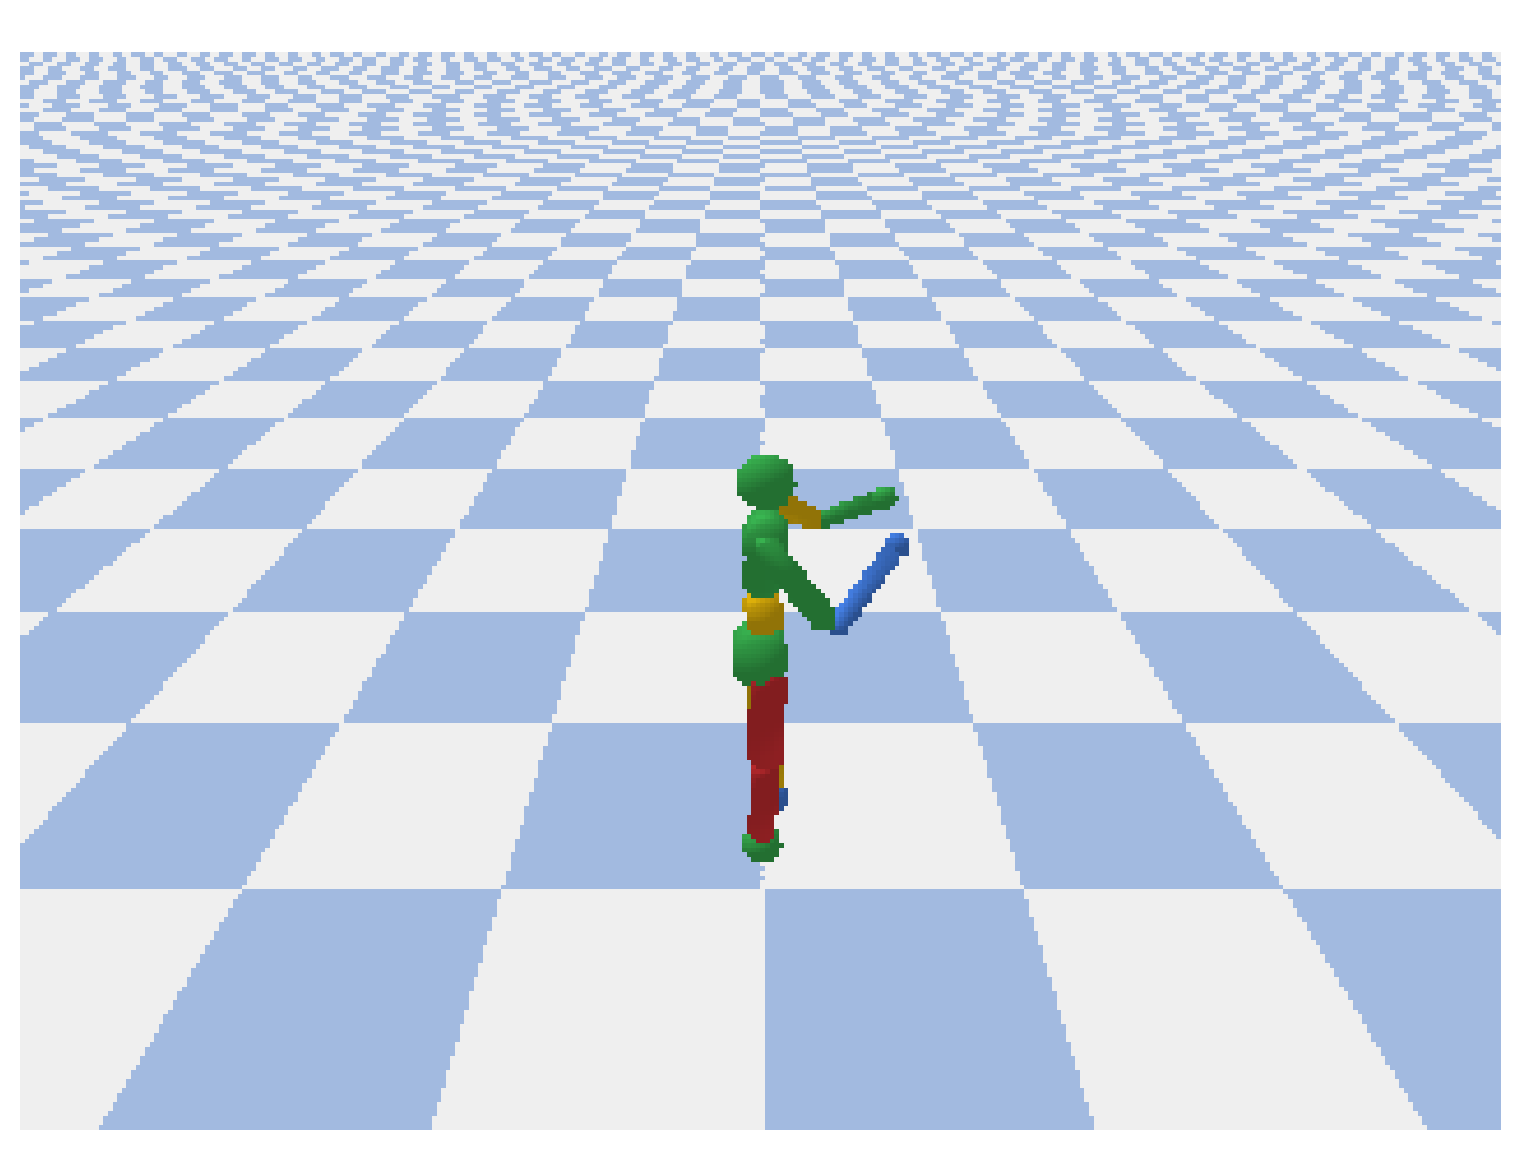

In [ ]:
_ = env.reset()

frame = env.environment.render(mode='rgb_array')
plt.imshow(frame)
plt.axis('off')
plt.show()

## Run the environment with random actions

We haven't trained the policy yet, but we can still see the environment in action by passing a random control sequence to it.

In [ ]:
# Run env for n_steps, apply random actions, and show video.
n_steps = 200

frames = []
timestep = env.reset()
for _ in range(n_steps):
  # Random control of actuators.
  action = np.random.uniform(action_spec.minimum,
                             action_spec.maximum,
                             size=action_spec.shape)
  timestep = env.step(action)
  frames.append(env.environment.render(mode='rgb_array'))

display_video(frames, framerate=20)

/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


## Lets take a look at some other environment properties

Notice the shapes and min/max limits

In [ ]:
print('Actions:\n', env_spec.actions)
print('Observations:\n', env_spec.observations)
print('Rewards:\n', env_spec.rewards)

Actions:
 BoundedArray(shape=(17,), dtype=dtype('float32'), name='action', minimum=[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], maximum=[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.])
Observations:
 BoundedArray(shape=(44,), dtype=dtype('float32'), name='observation', minimum=[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf], maximum=[inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf])
Rewards:
 Array(shape=(), dtype=dtype('float32'), name='reward')


## Inspect some of the robot properties

In [ ]:
# Cartesian coordinates of body parts.
for body_part in env.robot.parts.keys():
  print(f"{body_part:10} {env.robot.parts[body_part].pose().xyz()}")

link0_2    [-0.10262009  0.02161939  0.80935222]
torso      [-0.06593234 -0.01145737  0.85689693]
link0_3    [-0.10262009  0.02161939  0.80935222]
lwaist     [-0.08248995  0.04855611  0.75372678]
link0_5    [-0.06273955  0.07556219  0.69799655]
pelvis     [-0.05543131  0.07621966  0.59628049]
link0_7    [-0.04348693 -0.02682526  0.56107998]
link0_8    [-0.04348693 -0.02682526  0.56107998]
link0_9    [-0.04348693 -0.02682526  0.56107998]
right_thigh [ 0.11336514 -0.09080447  0.57621565]
link0_11   [ 0.30937371 -0.17203328  0.59561981]
right_shin [ 0.15947412 -0.12648383  0.52962463]
right_foot [-0.10505453 -0.04610246  0.41316255]
link0_14   [-0.00839873  0.17003619  0.56487353]
link0_15   [-0.00839873  0.17003619  0.56487353]
link0_16   [-0.00839873  0.17003619  0.56487353]
left_thigh [-0.01560966  0.2677643   0.42586914]
link0_18   [-0.02403712  0.39111271  0.25235216]
left_shin  [-0.06285998  0.31259447  0.39804935]
left_foot  [-0.1313709   0.17403289  0.65516203]
link0_21   [-0.0771

In [ ]:
# Cartesian components of robot speed.
env.robot_body.speed()

array([ 0.86874014, -0.36414718, -2.88204423])

---
# Create the `dm-acme` agent


First, lets configure loggers and optimizers:

In [ ]:
learner_log_every = 60.  # Learner logging frequency, seconds.
loop_log_every = 60.  # Environment loop logging frequency, seconds.
checkpoint = True  # Checkpoint saved every 10 minutes.

learner_logger = loggers.TerminalLogger(label='Learner',
                                        time_delta=learner_log_every,
                                        print_fn=print)
loop_logger = loggers.TerminalLogger(label='Environment Loop',
                                     time_delta=loop_log_every,
                                     print_fn=print)

# Note: optimizers can be passed only to the D4PG and DMPO agents.
# The optimizer for DDPG is hard-coded in the agent class.
policy_optimizer = snt.optimizers.Adam(1e-4)
critic_optimizer = snt.optimizers.Adam(1e-4)

---
# DDPG agent

In [ ]:
# Create networks.
policy_network, critic_network = make_networks_ddpg(action_spec)

# Create agent.
agent = DDPG(environment_spec=env_spec,
             policy_network=policy_network,
             critic_network=critic_network,
             observation_network= tf2_utils.batch_concat, # Identity Op.
             logger=learner_logger,
             checkpoint=checkpoint)

---
# Training

*Note:* `num_steps = 100_000` but we reduce it to 1000 to reduce computational time. Please change it back if you want to see the original output of the model.

In [ ]:
num_steps = 100_000  # Number of environment loop steps. Adjust as needed!

loop = environment_loop.EnvironmentLoop(env, agent, logger=loop_logger)

# Start training!
loop.run(num_episodes=None,
         num_steps=num_steps)

[Learner] Critic Loss = 32.547 | Policy Loss = 0.500 | Steps = 366 | Walltime = 38.355
[Environment Loop] Episode Length = 40 | Episode Return = 85.23685455322266 | Episodes = 127 | Steps = 3931 | Steps Per Second = 88.600
[Learner] Critic Loss = 320.505 | Policy Loss = 0.500 | Steps = 1128 | Walltime = 98.409
[Environment Loop] Episode Length = 61 | Episode Return = 151.46836853027344 | Episodes = 241 | Steps = 10081 | Steps Per Second = 110.527
[Learner] Critic Loss = 1418.208 | Policy Loss = 0.500 | Steps = 1878 | Walltime = 158.436
[Environment Loop] Episode Length = 54 | Episode Return = 102.64028930664062 | Episodes = 332 | Steps = 16095 | Steps Per Second = 117.717
[Learner] Critic Loss = 4606.615 | Policy Loss = 0.500 | Steps = 2651 | Walltime = 218.530
[Environment Loop] Episode Length = 81 | Episode Return = 338.6525573730469 | Episodes = 427 | Steps = 22294 | Steps Per Second = 72.094
[Learner] Critic Loss = 8978.162 | Policy Loss = 0.500 | Steps = 3409 | Walltime = 278.578


## Examine trained policy


- 학습된 정책을 환경에서 테스트하고 결과를 검토
- 테스트를 통해 에이전트가 얼마나 잘 수행되는지를 확인하고 각 타임스텝에서 얻는 보상을 수집하여 나중에 시각화

In [ ]:
# Run the environment with the learned policy and display video.
n_steps = 1000

frames = []  # Frames for video.
reward = [[]]  # Reward at every timestep.
timestep = env.reset()
for _ in range(n_steps):
  frames.append(env.environment.render(mode='rgb_array').copy())
  action = agent.select_action(timestep.observation)
  timestep = env.step(action)

  # `timestep.reward` is None when episode terminates.
  if timestep.reward:
    # Old episode continues.
    reward[-1].append(timestep.reward.item())
  else:
    # New episode begins.
    reward.append([])

display_video(frames)

/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


## Plot the reward

각 에피소드별 reward 비교
ddpg vs ddpg + reward(우리)

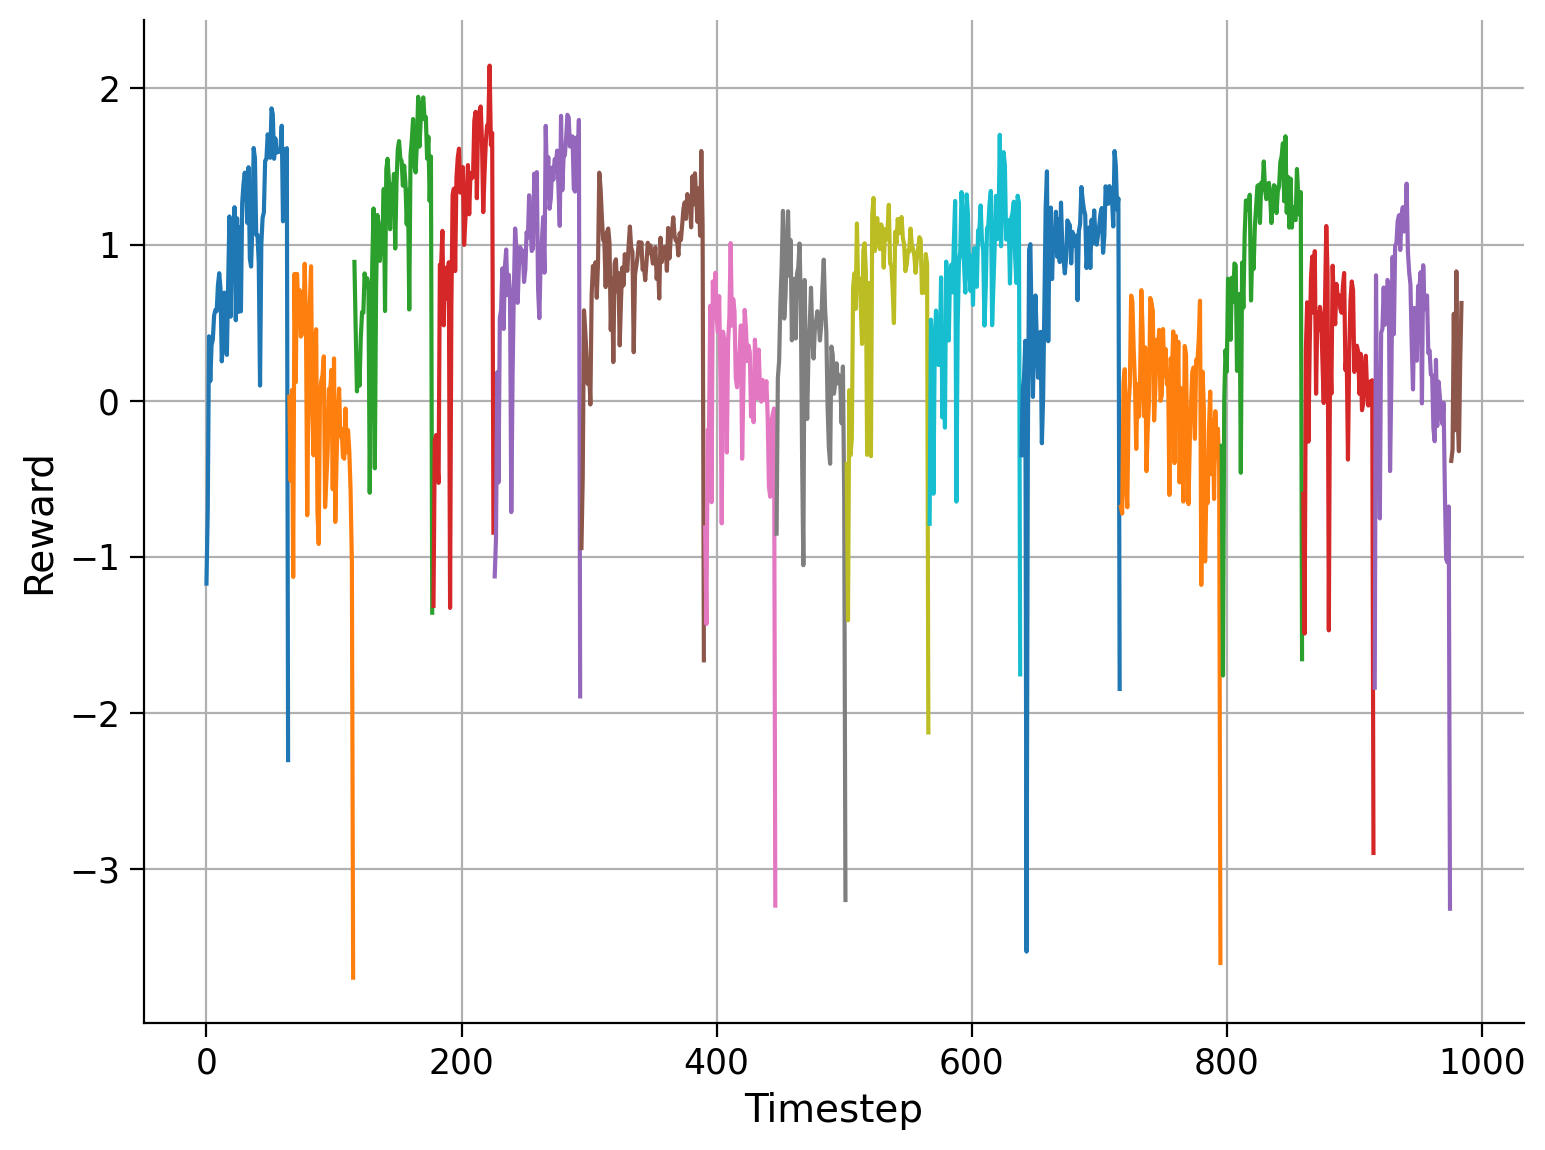

In [ ]:
env_step = 0
for episode in reward:
  plt.plot(np.arange(env_step, env_step+len(episode)), episode)
  env_step += len(episode)
plt.xlabel('Timestep', fontsize=14)
plt.ylabel('Reward', fontsize=14)
plt.grid()
plt.show()

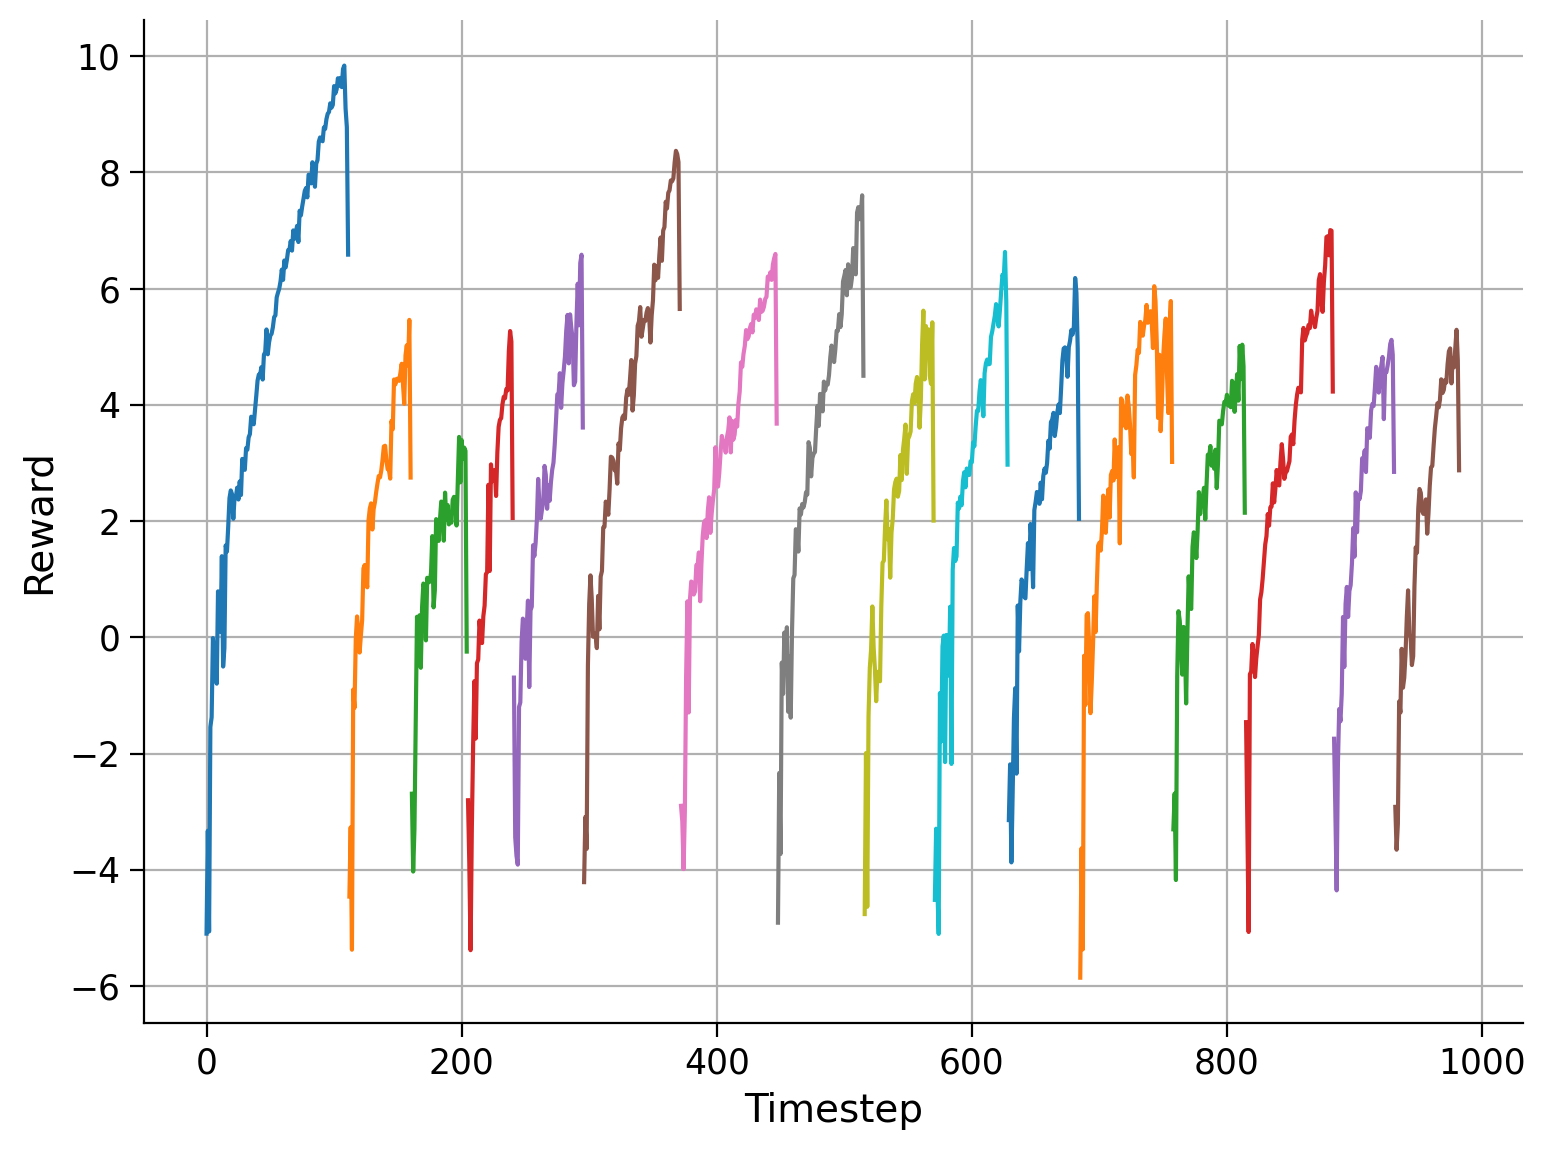

In [ ]:
env_step = 0
for episode in reward:
  plt.plot(np.arange(env_step, env_step+len(episode)), episode)
  env_step += len(episode)
plt.xlabel('Timestep', fontsize=14)
plt.ylabel('Reward', fontsize=14)
plt.grid()
plt.show()

## Total reward

테스트한 에피소드의 총 리워드 출력
ddpg vs ddpag + reward(우리)

In [ ]:
for i, episode in enumerate(reward):
  print(f"Total reward in episode {i}: {sum(episode):.2f}")

Total reward in episode 0: 62.13
Total reward in episode 1: -5.57
Total reward in episode 2: 68.69
Total reward in episode 3: 50.51
Total reward in episode 4: 67.78
Total reward in episode 5: 84.19
Total reward in episode 6: 4.28
Total reward in episode 7: 17.07
Total reward in episode 8: 48.25
Total reward in episode 9: 57.09
Total reward in episode 10: 64.02
Total reward in episode 11: -4.27
Total reward in episode 12: 61.79
Total reward in episode 13: 14.89
Total reward in episode 14: 17.78
Total reward in episode 15: 0.93


In [ ]:
for i, episode in enumerate(reward):
  print(f"Total reward in episode {i}: {sum(episode):.2f}")

Total reward in episode 0: 579.96
Total reward in episode 1: 107.02
Total reward in episode 2: 55.38
Total reward in episode 3: 52.79
Total reward in episode 4: 138.05
Total reward in episode 5: 308.04
Total reward in episode 6: 245.47
Total reward in episode 7: 233.30
Total reward in episode 8: 121.26
Total reward in episode 9: 147.88
Total reward in episode 10: 134.50
Total reward in episode 11: 216.03
Total reward in episode 12: 128.63
Total reward in episode 13: 221.97
Total reward in episode 14: 111.13
Total reward in episode 15: 109.22
Total reward in episode 16: -2.65
